In [1]:
import torch
from torch import nn
import torch.nn.utils.prune as prune
import torch.nn.functional as F
import os
import torchvision
import sklearn.metrics as metrics
import numpy as np
import seaborn as sns
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
from torchvision.utils import make_grid, save_image
import time


In [2]:
torch.cuda.set_device(0)

In [3]:
class opt:
    layer_num=784
    h_dim1=512
    h_dim2=256
    h_dim3=128
    h_dim4=64
    h_dim5 = 0
    h_dim6 = 0
    one_class=9
    lr=0.001
    finetune_epoch=10

In [4]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [5]:
class AE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, h_dim3,h_dim4):
        super(AE, self).__init__()
        self.x_dim = x_dim
        # encoder part
        self.encoder = Encoder(x_dim, h_dim1, h_dim2,  h_dim3,h_dim4)
        # decoder part
        self.decoder = Generator(x_dim, h_dim1, h_dim2, h_dim3,h_dim4)
    
    def recon_error(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return torch.norm((x_recon - x), dim=1)
    
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)
    
    def representation(self,x):
        z = self.encoder(x)
        return z
    
    def intermediate(self,x,layer):
        shapes = [(16,32),(16,16),(8,16),(8,8)]
        if layer<4:
            inter= self.encoder.intermediate(x,layer)
            return inter, shapes[layer]
        else:
            inter = self.encoder(x)
            inter= self.decoder.intermediate(inter,layer-4)
            return inter, shapes[2-layer]
            
        
class Encoder(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2,h_dim3,h_dim4):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc3 = nn.Linear(h_dim2, h_dim3)
        self.fc4 = nn.Linear(h_dim3,h_dim4)
    
    def forward(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        h = F.relu(self.fc3(h))
        h = self.fc4(h)
        return h
    
    def intermediate(self,x,layer):
        if layer==0:
            h = F.relu(self.fc1(x))
        elif layer==1:
            h = F.relu(self.fc1(x))
            h = F.relu(self.fc2(h))
        elif layer==2:
            h = F.relu(self.fc1(x))
            h = F.relu(self.fc2(h))
            h = F.relu(self.fc3(h))
        elif layer==3:
            h = F.relu(self.fc1(x))
            h = F.relu(self.fc2(h))
            h = F.relu(self.fc3(h))
            h = self.fc4(h)
            
        return h


    
class Generator(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2,h_dim3,h_dim4):
        super(Generator, self).__init__()
        self.fc4 = nn.Linear(h_dim4,h_dim3)
        self.fc3 = nn.Linear(h_dim3, h_dim2)
        self.fc2 = nn.Linear(h_dim2, h_dim1)
        self.fc1 = nn.Linear(h_dim1, x_dim)
    
    def forward(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc3(h))
        h = F.relu(self.fc2(h))
        return self.fc1(h)
    
    def intermediate(self,x,layer):
        if layer==0:
            h = F.relu(self.fc4(x))
        elif layer==1:
            h = F.relu(self.fc4(x))
            h = F.relu(self.fc3(h))
        elif layer==2:
            h = F.relu(self.fc4(x))
            h = F.relu(self.fc3(h))
            h = F.relu(self.fc2(h))
        elif layer==3:
            h = F.relu(self.fc4(x))
            h = F.relu(self.fc3(h))
            h = F.relu(self.fc2(h))
            h = self.fc1(h)
        return h

model = AE(opt.layer_num, opt.h_dim1, opt.h_dim2, opt.h_dim3,opt.h_dim4)

In [6]:
model_name = 'MNIST_{}_{}_{}_{}_{}_{}'.format(opt.h_dim1, opt.h_dim2, opt.h_dim3, opt.h_dim4, opt.h_dim5, opt.h_dim6)
model_path = model_name+'_holdout_{}_epoch_100.pth'.format(opt.one_class)

In [7]:
model.load_state_dict(torch.load(os.path.join('../model-compression/trained_model',model_path),map_location=torch.device('cpu')))

<All keys matched successfully>

In [8]:
model

AE(
  (encoder): Encoder(
    (fc1): Linear(in_features=784, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=256, bias=True)
    (fc3): Linear(in_features=256, out_features=128, bias=True)
    (fc4): Linear(in_features=128, out_features=64, bias=True)
  )
  (decoder): Generator(
    (fc4): Linear(in_features=64, out_features=128, bias=True)
    (fc3): Linear(in_features=128, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=512, bias=True)
    (fc1): Linear(in_features=512, out_features=784, bias=True)
  )
)

In [9]:
mnist_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(), 
    torchvision.transforms.Normalize((0.5,), (1.0,))
])

ind_dataset = torchvision.datasets.MNIST('./dataset', transform=mnist_transform, train=False, download=True)
train_dataset = torchvision.datasets.MNIST('./dataset', transform=mnist_transform, train=True, download=True)

idx = train_dataset.targets!=opt.one_class
train_dataset.targets = train_dataset.targets[idx]
train_dataset.data = train_dataset.data[idx]

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                         batch_size=64,
                         shuffle=True)

idx = ind_dataset.targets!=opt.one_class
ind_dataset.targets = ind_dataset.targets[idx]
ind_dataset.data = ind_dataset.data[idx]

ind_loader = torch.utils.data.DataLoader(dataset=ind_dataset, 
                         batch_size=64,
                         shuffle=False)

In [10]:
mnist_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(), 
    torchvision.transforms.Normalize((0.5,), (1.0,))
])

ood_dataset = torchvision.datasets.MNIST('./dataset', transform=mnist_transform, train=False, download=True)

idx = ood_dataset.targets==opt.one_class
ood_dataset.targets = ood_dataset.targets[idx]
ood_dataset.data = ood_dataset.data[idx]

ood_loader = torch.utils.data.DataLoader(dataset=ood_dataset, 
                         batch_size=64,
                         shuffle=False)

In [11]:
model.eval()
model.cuda()
avg_loss = 0
step = 0
for i, (data,label) in enumerate(ind_loader):
    step += 1
    data = data.reshape(-1,784).cuda()
    with torch.no_grad():
        recon_error = model.recon_error(data)
        representation = model.representation(data)
    if i==0:
        ind_recon = recon_error
        ind_latents = representation
    else:
        ind_recon=torch.cat((ind_recon,recon_error),0)
        ind_latents=torch.cat((ind_latents,representation),0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


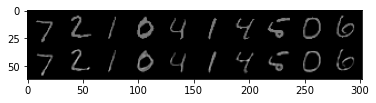

In [12]:
'''check inlier reconstruction'''
test_data = torch.stack([ind_loader.dataset[i][0] for i in range(10)])
recon = model(test_data.reshape(-1,784).cuda()).detach().cpu()
recon = torch.clamp(recon.view(len(recon), 1, 28, 28), 0, 1)
x_and_recon = torch.cat([test_data, recon])
img_grid = make_grid(x_and_recon.detach().cpu(), nrow=10, range=(0, 1))
# writer.add_image('supermask_{}/inlier_recon'.format(sparsity), img_grid, i+1)
plt.imshow(img_grid.cpu().numpy().transpose(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


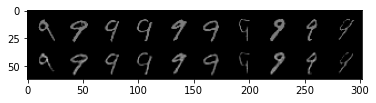

In [13]:
'''check outlier reconstruction'''
test_data = torch.stack([ood_loader.dataset[i][0] for i in range(10)])
recon = model(test_data.reshape(-1,784).cuda()).detach().cpu()
recon = torch.clamp(recon.view(len(recon), 1, 28, 28), 0, 1)
x_and_recon = torch.cat([test_data, recon])
img_grid = make_grid(x_and_recon.detach().cpu(), nrow=10, range=(0, 1))
# writer.add_image('supermask_{}/outier_recon'.format(sparsity), img_grid, i+1)
plt.imshow(img_grid.cpu().numpy().transpose(1,2,0))

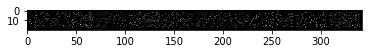

In [14]:
'''check encoder first layer'''
layer_index = 6

test_data = torch.stack([ind_loader.dataset[i][0] for i in range(10)])
recon, (s1,s2) = model.intermediate(test_data.reshape(-1,784).cuda(),layer_index)
recon = recon.detach().cpu()
recon = torch.clamp(recon.view(len(recon), 1, s1, s2), 0, 1)
# x_and_recon = torch.cat([test_data, recon])
img_grid = make_grid(recon.detach().cpu(), nrow=10, range=(0, 1))
# writer.add_image('supermask_{}/inlier_recon'.format(sparsity), img_grid, i+1)
plt.imshow(img_grid.cpu().numpy().transpose(1,2,0))

In [15]:
model.eval()
avg_loss = 0
step = 0
for i, (data,label) in enumerate(ood_loader):
    step += 1
    data = data.reshape(-1,784).cuda()
    with torch.no_grad():
        recon_error = model.recon_error(data)
        representation = model.representation(data)
        
    if i==0:
        ood_recon = recon_error
        ood_latents = representation

    else:
        ood_recon=torch.cat((ood_recon,recon_error),0)
        ood_latents=torch.cat((ood_latents,representation),0)

In [16]:
ind_latents.shape, ood_latents.shape

(torch.Size([8991, 64]), torch.Size([1009, 64]))

In [17]:
# from sklearn.manifold import TSNE

# TSNE_ind_latents = TSNE(n_components=2).fit_transform(ind_latents.cpu().numpy())
# TSNE_ood_latents = TSNE(n_components=2).fit_transform(ood_latents.cpu().numpy())

In [18]:
# plt.scatter(TSNE_ind_latents[:,0],TSNE_ind_latents[:,1])
# plt.scatter(TSNE_ood_latents[:,0],TSNE_ood_latents[:,1])

In [19]:
# ind_recon.shape, ood_recon.shape

<AxesSubplot:ylabel='Density'>

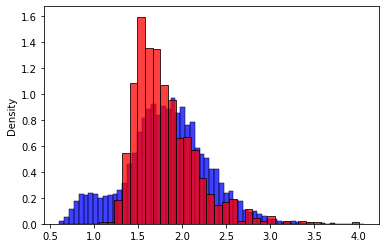

In [20]:
sns.histplot(ind_recon.detach().cpu().numpy(),color='blue',stat='density')
sns.histplot(ood_recon.detach().cpu().numpy(),color='red',stat='density')

In [21]:
torch.mean(ind_recon), torch.mean(ood_recon)

(tensor(1.8250, device='cuda:0'), tensor(1.8040, device='cuda:0'))

In [22]:
ind_size=ind_recon.detach().cpu().numpy().shape[0]
ood_size=ood_recon.detach().cpu().numpy().shape[0]

metrics.roc_auc_score(np.concatenate((np.zeros(ind_size),np.ones(ood_size))),np.concatenate((ind_recon.detach().cpu().numpy(),ood_recon.detach().cpu().numpy())))

0.4590050352080965

In [23]:
print(
    "Global sparsity: {:.2f}%".format(
        100. * float(
            torch.sum(model.encoder.fc1.weight == 0)
            + torch.sum(model.encoder.fc2.weight == 0)
            + torch.sum(model.encoder.fc3.weight == 0)
            + torch.sum(model.encoder.fc4.weight == 0)
            
            + torch.sum(model.decoder.fc1.weight == 0)
            + torch.sum(model.decoder.fc2.weight == 0)
            + torch.sum(model.decoder.fc3.weight == 0)
            + torch.sum(model.decoder.fc4.weight == 0)

        )
        / count_parameters(model)
        )
    )

Global sparsity: 0.00%


### After Pruning

creating ./back_to_basics/leaveout_9
0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


before finetuning : auroc = 0.4590050352080965
Global sparsity before finetuned: 0.00%


 10%|█         | 1/10 [00:11<01:41, 11.32s/it]

Epoch [1/10] Batch [15/845]=> Loss: 1.82662


 20%|██        | 2/10 [00:21<01:24, 10.51s/it]

Epoch [2/10] Batch [15/845]=> Loss: 1.79476


 30%|███       | 3/10 [00:32<01:14, 10.70s/it]

Epoch [3/10] Batch [15/845]=> Loss: 1.79139


 40%|████      | 4/10 [00:43<01:04, 10.82s/it]

Epoch [4/10] Batch [15/845]=> Loss: 1.79075


 50%|█████     | 5/10 [00:54<00:54, 10.89s/it]

Epoch [5/10] Batch [15/845]=> Loss: 1.78838


 60%|██████    | 6/10 [01:05<00:43, 11.00s/it]

Epoch [6/10] Batch [15/845]=> Loss: 1.78649


 70%|███████   | 7/10 [01:16<00:33, 11.02s/it]

Epoch [7/10] Batch [15/845]=> Loss: 1.78889


 80%|████████  | 8/10 [01:27<00:21, 10.98s/it]

Epoch [8/10] Batch [15/845]=> Loss: 1.78628


 90%|█████████ | 9/10 [01:38<00:10, 10.98s/it]

Epoch [9/10] Batch [15/845]=> Loss: 1.78206


100%|██████████| 10/10 [01:49<00:00, 10.94s/it]

Epoch [10/10] Batch [15/845]=> Loss: 1.78293



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


after finetuning : auroc = 0.4793176614561924
Global sparsity after finetuned: 0.00%
0.1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


before finetuning : auroc = 0.4590359547963337
Global sparsity before finetuned: 9.98%


 10%|█         | 1/10 [00:11<01:39, 11.09s/it]

Epoch [1/10] Batch [15/845]=> Loss: 1.81694


 20%|██        | 2/10 [00:22<01:28, 11.03s/it]

Epoch [2/10] Batch [15/845]=> Loss: 1.78803


 30%|███       | 3/10 [00:33<01:17, 11.02s/it]

Epoch [3/10] Batch [15/845]=> Loss: 1.78614


 40%|████      | 4/10 [00:44<01:05, 10.99s/it]

Epoch [4/10] Batch [15/845]=> Loss: 1.78069


 50%|█████     | 5/10 [00:54<00:54, 10.98s/it]

Epoch [5/10] Batch [15/845]=> Loss: 1.78316


 60%|██████    | 6/10 [01:06<00:44, 11.00s/it]

Epoch [6/10] Batch [15/845]=> Loss: 1.78308


 70%|███████   | 7/10 [01:17<00:32, 10.99s/it]

Epoch [7/10] Batch [15/845]=> Loss: 1.77949


 80%|████████  | 8/10 [01:28<00:21, 10.99s/it]

Epoch [8/10] Batch [15/845]=> Loss: 1.77699


 90%|█████████ | 9/10 [01:38<00:10, 10.98s/it]

Epoch [9/10] Batch [15/845]=> Loss: 1.77649


100%|██████████| 10/10 [01:49<00:00, 10.99s/it]

Epoch [10/10] Batch [15/845]=> Loss: 1.77487



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


after finetuning : auroc = 0.4648902288479428
Global sparsity after finetuned: 9.98%
0.3


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


before finetuning : auroc = 0.4371490199592832
Global sparsity before finetuned: 29.93%


 10%|█         | 1/10 [00:10<01:38, 10.99s/it]

Epoch [1/10] Batch [15/845]=> Loss: 1.79416


 20%|██        | 2/10 [00:21<01:27, 10.98s/it]

Epoch [2/10] Batch [15/845]=> Loss: 1.76687


 30%|███       | 3/10 [00:32<01:16, 10.94s/it]

Epoch [3/10] Batch [15/845]=> Loss: 1.76449


 40%|████      | 4/10 [00:43<01:05, 10.92s/it]

Epoch [4/10] Batch [15/845]=> Loss: 1.76176


 50%|█████     | 5/10 [00:54<00:54, 10.90s/it]

Epoch [5/10] Batch [15/845]=> Loss: 1.76120


 60%|██████    | 6/10 [01:05<00:43, 10.94s/it]

Epoch [6/10] Batch [15/845]=> Loss: 1.75994


 70%|███████   | 7/10 [01:16<00:32, 10.93s/it]

Epoch [7/10] Batch [15/845]=> Loss: 1.75871


 80%|████████  | 8/10 [01:27<00:21, 10.93s/it]

Epoch [8/10] Batch [15/845]=> Loss: 1.75498


 90%|█████████ | 9/10 [01:38<00:10, 10.94s/it]

Epoch [9/10] Batch [15/845]=> Loss: 1.75644


100%|██████████| 10/10 [01:49<00:00, 10.94s/it]

Epoch [10/10] Batch [15/845]=> Loss: 1.75467



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


after finetuning : auroc = 0.4743549848714478
Global sparsity after finetuned: 29.93%
0.5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


before finetuning : auroc = 0.38986833987384584
Global sparsity before finetuned: 49.89%


 10%|█         | 1/10 [00:10<01:37, 10.88s/it]

Epoch [1/10] Batch [15/845]=> Loss: 1.79391


 20%|██        | 2/10 [00:21<01:27, 10.94s/it]

Epoch [2/10] Batch [15/845]=> Loss: 1.75515


 30%|███       | 3/10 [00:32<01:16, 10.95s/it]

Epoch [3/10] Batch [15/845]=> Loss: 1.75031


 40%|████      | 4/10 [00:43<01:05, 10.93s/it]

Epoch [4/10] Batch [15/845]=> Loss: 1.74844


 50%|█████     | 5/10 [00:54<00:54, 10.95s/it]

Epoch [5/10] Batch [15/845]=> Loss: 1.74317


 60%|██████    | 6/10 [01:05<00:43, 10.94s/it]

Epoch [6/10] Batch [15/845]=> Loss: 1.74173


 70%|███████   | 7/10 [01:16<00:32, 10.92s/it]

Epoch [7/10] Batch [15/845]=> Loss: 1.74164


 80%|████████  | 8/10 [01:27<00:21, 10.94s/it]

Epoch [8/10] Batch [15/845]=> Loss: 1.73966


 90%|█████████ | 9/10 [01:38<00:10, 10.95s/it]

Epoch [9/10] Batch [15/845]=> Loss: 1.73874


100%|██████████| 10/10 [01:49<00:00, 10.93s/it]

Epoch [10/10] Batch [15/845]=> Loss: 1.73811



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


after finetuning : auroc = 0.45300569813288677
Global sparsity after finetuned: 49.89%
0.7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


before finetuning : auroc = 0.3744249700642169
Global sparsity before finetuned: 69.84%


 10%|█         | 1/10 [00:11<01:39, 11.04s/it]

Epoch [1/10] Batch [15/845]=> Loss: 1.88517


 20%|██        | 2/10 [00:21<01:27, 10.98s/it]

Epoch [2/10] Batch [15/845]=> Loss: 1.77203


 30%|███       | 3/10 [00:32<01:16, 10.98s/it]

Epoch [3/10] Batch [15/845]=> Loss: 1.76037


 40%|████      | 4/10 [00:43<01:05, 10.97s/it]

Epoch [4/10] Batch [15/845]=> Loss: 1.75386


 50%|█████     | 5/10 [00:54<00:54, 10.96s/it]

Epoch [5/10] Batch [15/845]=> Loss: 1.74947


 60%|██████    | 6/10 [01:05<00:43, 10.98s/it]

Epoch [6/10] Batch [15/845]=> Loss: 1.74530


 70%|███████   | 7/10 [01:16<00:32, 11.00s/it]

Epoch [7/10] Batch [15/845]=> Loss: 1.74247


 80%|████████  | 8/10 [01:27<00:21, 10.99s/it]

Epoch [8/10] Batch [15/845]=> Loss: 1.74117


 90%|█████████ | 9/10 [01:38<00:10, 10.97s/it]

Epoch [9/10] Batch [15/845]=> Loss: 1.73789


100%|██████████| 10/10 [01:49<00:00, 10.99s/it]

Epoch [10/10] Batch [15/845]=> Loss: 1.73686



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


after finetuning : auroc = 0.4611287314183471
Global sparsity after finetuned: 69.84%
0.8


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


before finetuning : auroc = 0.39546406884805735
Global sparsity before finetuned: 79.82%


 10%|█         | 1/10 [00:10<01:38, 10.95s/it]

Epoch [1/10] Batch [15/845]=> Loss: 2.09019


 20%|██        | 2/10 [00:21<01:27, 10.98s/it]

Epoch [2/10] Batch [15/845]=> Loss: 1.82970


 30%|███       | 3/10 [00:32<01:16, 10.97s/it]

Epoch [3/10] Batch [15/845]=> Loss: 1.80144


 40%|████      | 4/10 [00:43<01:05, 10.97s/it]

Epoch [4/10] Batch [15/845]=> Loss: 1.78896


 50%|█████     | 5/10 [00:54<00:54, 10.99s/it]

Epoch [5/10] Batch [15/845]=> Loss: 1.77970


 60%|██████    | 6/10 [01:05<00:43, 10.98s/it]

Epoch [6/10] Batch [15/845]=> Loss: 1.77372


 70%|███████   | 7/10 [01:16<00:32, 10.98s/it]

Epoch [7/10] Batch [15/845]=> Loss: 1.76825


 80%|████████  | 8/10 [01:27<00:21, 10.97s/it]

Epoch [8/10] Batch [15/845]=> Loss: 1.76477


 90%|█████████ | 9/10 [01:38<00:10, 10.99s/it]

Epoch [9/10] Batch [15/845]=> Loss: 1.76145


100%|██████████| 10/10 [01:49<00:00, 10.98s/it]

Epoch [10/10] Batch [15/845]=> Loss: 1.75822



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


after finetuning : auroc = 0.4546239334808876
Global sparsity after finetuned: 79.82%
0.9


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


before finetuning : auroc = 0.3781575871654057
Global sparsity before finetuned: 89.79%


 10%|█         | 1/10 [00:11<01:40, 11.15s/it]

Epoch [1/10] Batch [15/845]=> Loss: 3.09133


 20%|██        | 2/10 [00:22<01:30, 11.26s/it]

Epoch [2/10] Batch [15/845]=> Loss: 2.30511


 30%|███       | 3/10 [00:33<01:17, 11.08s/it]

Epoch [3/10] Batch [15/845]=> Loss: 2.17635


 40%|████      | 4/10 [00:44<01:06, 11.04s/it]

Epoch [4/10] Batch [15/845]=> Loss: 2.11065


 50%|█████     | 5/10 [00:55<00:55, 11.04s/it]

Epoch [5/10] Batch [15/845]=> Loss: 2.06898


 60%|██████    | 6/10 [01:06<00:44, 11.03s/it]

Epoch [6/10] Batch [15/845]=> Loss: 2.03847


 70%|███████   | 7/10 [01:17<00:33, 11.04s/it]

Epoch [7/10] Batch [15/845]=> Loss: 2.01526


 80%|████████  | 8/10 [01:28<00:22, 11.02s/it]

Epoch [8/10] Batch [15/845]=> Loss: 1.99694


 90%|█████████ | 9/10 [01:39<00:11, 11.01s/it]

Epoch [9/10] Batch [15/845]=> Loss: 1.98052


100%|██████████| 10/10 [01:50<00:00, 11.05s/it]

Epoch [10/10] Batch [15/845]=> Loss: 1.96747



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


after finetuning : auroc = 0.4578089817600885
Global sparsity after finetuned: 89.79%
0.91


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


before finetuning : auroc = 0.3948339375605095
Global sparsity before finetuned: 90.79%


 10%|█         | 1/10 [00:11<01:39, 11.04s/it]

Epoch [1/10] Batch [15/845]=> Loss: 3.34593


 20%|██        | 2/10 [00:22<01:28, 11.07s/it]

Epoch [2/10] Batch [15/845]=> Loss: 2.45719


 30%|███       | 3/10 [00:31<01:11, 10.22s/it]

Epoch [3/10] Batch [15/845]=> Loss: 2.30424


 40%|████      | 4/10 [00:40<00:58,  9.82s/it]

Epoch [4/10] Batch [15/845]=> Loss: 2.22672


 50%|█████     | 5/10 [00:49<00:48,  9.61s/it]

Epoch [5/10] Batch [15/845]=> Loss: 2.17765


 60%|██████    | 6/10 [00:58<00:37,  9.47s/it]

Epoch [6/10] Batch [15/845]=> Loss: 2.14086


 70%|███████   | 7/10 [01:08<00:28,  9.39s/it]

Epoch [7/10] Batch [15/845]=> Loss: 2.11278


 80%|████████  | 8/10 [01:17<00:18,  9.35s/it]

Epoch [8/10] Batch [15/845]=> Loss: 2.09024


 90%|█████████ | 9/10 [01:26<00:09,  9.31s/it]

Epoch [9/10] Batch [15/845]=> Loss: 2.07133


100%|██████████| 10/10 [01:35<00:00,  9.59s/it]

Epoch [10/10] Batch [15/845]=> Loss: 2.05431



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


after finetuning : auroc = 0.4695418907510087
Global sparsity after finetuned: 90.79%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.92


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


before finetuning : auroc = 0.405322898054976


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Global sparsity before finetuned: 91.79%


 10%|█         | 1/10 [00:09<01:22,  9.22s/it]

Epoch [1/10] Batch [15/845]=> Loss: 3.60777


 20%|██        | 2/10 [00:20<01:22, 10.29s/it]

Epoch [2/10] Batch [15/845]=> Loss: 2.64452


 30%|███       | 3/10 [00:31<01:14, 10.63s/it]

Epoch [3/10] Batch [15/845]=> Loss: 2.46497


 40%|████      | 4/10 [00:42<01:04, 10.79s/it]

Epoch [4/10] Batch [15/845]=> Loss: 2.36835


 50%|█████     | 5/10 [00:53<00:54, 10.89s/it]

Epoch [5/10] Batch [15/845]=> Loss: 2.30584


 60%|██████    | 6/10 [01:04<00:43, 10.94s/it]

Epoch [6/10] Batch [15/845]=> Loss: 2.25941


 70%|███████   | 7/10 [01:15<00:32, 10.97s/it]

Epoch [7/10] Batch [15/845]=> Loss: 2.22389


 80%|████████  | 8/10 [01:26<00:22, 11.01s/it]

Epoch [8/10] Batch [15/845]=> Loss: 2.19526


 90%|█████████ | 9/10 [01:37<00:11, 11.03s/it]

Epoch [9/10] Batch [15/845]=> Loss: 2.17234


100%|██████████| 10/10 [01:48<00:00, 10.86s/it]

Epoch [10/10] Batch [15/845]=> Loss: 2.15282



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


after finetuning : auroc = 0.468196640644609
Global sparsity after finetuned: 91.79%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.925


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


before finetuning : auroc = 0.40995901749122754


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Global sparsity before finetuned: 92.29%


 10%|█         | 1/10 [00:10<01:38, 10.98s/it]

Epoch [1/10] Batch [15/845]=> Loss: 3.78835


 20%|██        | 2/10 [00:22<01:28, 11.01s/it]

Epoch [2/10] Batch [15/845]=> Loss: 2.72653


 30%|███       | 3/10 [00:34<01:20, 11.54s/it]

Epoch [3/10] Batch [15/845]=> Loss: 2.52824


 40%|████      | 4/10 [00:45<01:08, 11.37s/it]

Epoch [4/10] Batch [15/845]=> Loss: 2.42525


 50%|█████     | 5/10 [00:56<00:56, 11.25s/it]

Epoch [5/10] Batch [15/845]=> Loss: 2.35910


 60%|██████    | 6/10 [01:07<00:44, 11.18s/it]

Epoch [6/10] Batch [15/845]=> Loss: 2.30953


 70%|███████   | 7/10 [01:18<00:33, 11.19s/it]

Epoch [7/10] Batch [15/845]=> Loss: 2.27109


 80%|████████  | 8/10 [01:29<00:22, 11.13s/it]

Epoch [8/10] Batch [15/845]=> Loss: 2.24017


 90%|█████████ | 9/10 [01:40<00:11, 11.10s/it]

Epoch [9/10] Batch [15/845]=> Loss: 2.21671


100%|██████████| 10/10 [01:51<00:00, 11.16s/it]

Epoch [10/10] Batch [15/845]=> Loss: 2.19605



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


after finetuning : auroc = 0.4657307345887899
Global sparsity after finetuned: 92.29%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.93


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


before finetuning : auroc = 0.4045449479873001


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Global sparsity before finetuned: 92.79%


 10%|█         | 1/10 [00:11<01:39, 11.09s/it]

Epoch [1/10] Batch [15/845]=> Loss: 3.96416


 20%|██        | 2/10 [00:22<01:28, 11.05s/it]

Epoch [2/10] Batch [15/845]=> Loss: 2.81893


 30%|███       | 3/10 [00:33<01:17, 11.01s/it]

Epoch [3/10] Batch [15/845]=> Loss: 2.60942


 40%|████      | 4/10 [00:44<01:06, 11.04s/it]

Epoch [4/10] Batch [15/845]=> Loss: 2.49975


 50%|█████     | 5/10 [00:55<00:55, 11.03s/it]

Epoch [5/10] Batch [15/845]=> Loss: 2.42829


 60%|██████    | 6/10 [01:06<00:44, 11.02s/it]

Epoch [6/10] Batch [15/845]=> Loss: 2.37772


 70%|███████   | 7/10 [01:17<00:33, 11.01s/it]

Epoch [7/10] Batch [15/845]=> Loss: 2.33769


 80%|████████  | 8/10 [01:28<00:22, 11.05s/it]

Epoch [8/10] Batch [15/845]=> Loss: 2.30665


 90%|█████████ | 9/10 [01:39<00:11, 11.07s/it]

Epoch [9/10] Batch [15/845]=> Loss: 2.28117


100%|██████████| 10/10 [01:50<00:00, 11.04s/it]

Epoch [10/10] Batch [15/845]=> Loss: 2.25763



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


after finetuning : auroc = 0.4687548466867925
Global sparsity after finetuned: 92.79%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.935


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


before finetuning : auroc = 0.3998003619741314


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Global sparsity before finetuned: 93.29%


 10%|█         | 1/10 [00:10<01:38, 10.97s/it]

Epoch [1/10] Batch [15/845]=> Loss: 4.12415


 20%|██        | 2/10 [00:20<01:19,  9.95s/it]

Epoch [2/10] Batch [15/845]=> Loss: 2.93930


 30%|███       | 3/10 [00:29<01:07,  9.60s/it]

Epoch [3/10] Batch [15/845]=> Loss: 2.71462


 40%|████      | 4/10 [00:38<00:56,  9.43s/it]

Epoch [4/10] Batch [15/845]=> Loss: 2.59411


 50%|█████     | 5/10 [00:47<00:46,  9.34s/it]

Epoch [5/10] Batch [15/845]=> Loss: 2.51811


 60%|██████    | 6/10 [00:56<00:37,  9.29s/it]

Epoch [6/10] Batch [15/845]=> Loss: 2.46344


 70%|███████   | 7/10 [01:06<00:27,  9.26s/it]

Epoch [7/10] Batch [15/845]=> Loss: 2.41989


 80%|████████  | 8/10 [01:15<00:18,  9.25s/it]

Epoch [8/10] Batch [15/845]=> Loss: 2.38304


 90%|█████████ | 9/10 [01:24<00:09,  9.23s/it]

Epoch [9/10] Batch [15/845]=> Loss: 2.35207


100%|██████████| 10/10 [01:33<00:00,  9.37s/it]

Epoch [10/10] Batch [15/845]=> Loss: 2.32530



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


after finetuning : auroc = 0.47464218981673006
Global sparsity after finetuned: 93.29%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.94


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


before finetuning : auroc = 0.4119510987697311


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Global sparsity before finetuned: 93.78%


 10%|█         | 1/10 [00:09<01:22,  9.19s/it]

Epoch [1/10] Batch [15/845]=> Loss: 4.41474


 20%|██        | 2/10 [00:18<01:13,  9.19s/it]

Epoch [2/10] Batch [15/845]=> Loss: 3.10197


 30%|███       | 3/10 [00:27<01:04,  9.21s/it]

Epoch [3/10] Batch [15/845]=> Loss: 2.85232


 40%|████      | 4/10 [00:36<00:55,  9.20s/it]

Epoch [4/10] Batch [15/845]=> Loss: 2.71989


 50%|█████     | 5/10 [00:47<00:49,  9.82s/it]

Epoch [5/10] Batch [15/845]=> Loss: 2.63032


 60%|██████    | 6/10 [00:58<00:40, 10.23s/it]

Epoch [6/10] Batch [15/845]=> Loss: 2.56713


 70%|███████   | 7/10 [01:09<00:31, 10.50s/it]

Epoch [7/10] Batch [15/845]=> Loss: 2.51769


 80%|████████  | 8/10 [01:20<00:21, 10.65s/it]

Epoch [8/10] Batch [15/845]=> Loss: 2.48080


 90%|█████████ | 9/10 [01:31<00:10, 10.74s/it]

Epoch [9/10] Batch [15/845]=> Loss: 2.44925


100%|██████████| 10/10 [01:42<00:00, 10.27s/it]

Epoch [10/10] Batch [15/845]=> Loss: 2.42472



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


after finetuning : auroc = 0.47280564343663123
Global sparsity after finetuned: 93.78%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.945


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


before finetuning : auroc = 0.4162607712877507


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Global sparsity before finetuned: 94.28%


 10%|█         | 1/10 [00:11<01:39, 11.01s/it]

Epoch [1/10] Batch [15/845]=> Loss: 4.66421


 20%|██        | 2/10 [00:22<01:28, 11.00s/it]

Epoch [2/10] Batch [15/845]=> Loss: 3.33896


 30%|███       | 3/10 [00:32<01:16, 10.99s/it]

Epoch [3/10] Batch [15/845]=> Loss: 3.05387


 40%|████      | 4/10 [00:43<01:05, 10.99s/it]

Epoch [4/10] Batch [15/845]=> Loss: 2.90033


 50%|█████     | 5/10 [00:54<00:54, 10.98s/it]

Epoch [5/10] Batch [15/845]=> Loss: 2.80425


 60%|██████    | 6/10 [01:05<00:43, 10.99s/it]

Epoch [6/10] Batch [15/845]=> Loss: 2.73334


 70%|███████   | 7/10 [01:16<00:32, 11.00s/it]

Epoch [7/10] Batch [15/845]=> Loss: 2.67896


 80%|████████  | 8/10 [01:27<00:22, 11.01s/it]

Epoch [8/10] Batch [15/845]=> Loss: 2.63433


 90%|█████████ | 9/10 [01:38<00:11, 11.00s/it]

Epoch [9/10] Batch [15/845]=> Loss: 2.59741


100%|██████████| 10/10 [01:49<00:00, 11.00s/it]

Epoch [10/10] Batch [15/845]=> Loss: 2.56587



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


after finetuning : auroc = 0.4567091593300161
Global sparsity after finetuned: 94.28%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.95


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


before finetuning : auroc = 0.41659581616634805


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Global sparsity before finetuned: 94.78%


 10%|█         | 1/10 [00:10<01:38, 10.98s/it]

Epoch [1/10] Batch [15/845]=> Loss: 4.95192


 20%|██        | 2/10 [00:21<01:27, 10.97s/it]

Epoch [2/10] Batch [15/845]=> Loss: 3.51621


 30%|███       | 3/10 [00:32<01:17, 11.00s/it]

Epoch [3/10] Batch [15/845]=> Loss: 3.21138


 40%|████      | 4/10 [00:43<01:05, 10.99s/it]

Epoch [4/10] Batch [15/845]=> Loss: 3.06972


 50%|█████     | 5/10 [00:54<00:54, 10.98s/it]

Epoch [5/10] Batch [15/845]=> Loss: 2.97833


 60%|██████    | 6/10 [01:05<00:43, 10.98s/it]

Epoch [6/10] Batch [15/845]=> Loss: 2.91183


 70%|███████   | 7/10 [01:16<00:32, 10.97s/it]

Epoch [7/10] Batch [15/845]=> Loss: 2.85792


 80%|████████  | 8/10 [01:27<00:21, 10.98s/it]

Epoch [8/10] Batch [15/845]=> Loss: 2.81419


 90%|█████████ | 9/10 [01:38<00:11, 11.00s/it]

Epoch [9/10] Batch [15/845]=> Loss: 2.77910


100%|██████████| 10/10 [01:49<00:00, 10.99s/it]

Epoch [10/10] Batch [15/845]=> Loss: 2.74869



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


after finetuning : auroc = 0.4560912636014497
Global sparsity after finetuned: 94.78%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.955


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


before finetuning : auroc = 0.4171213940512476


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Global sparsity before finetuned: 95.28%


 10%|█         | 1/10 [00:10<01:38, 10.96s/it]

Epoch [1/10] Batch [15/845]=> Loss: 5.50897


 20%|██        | 2/10 [00:22<01:28, 11.04s/it]

Epoch [2/10] Batch [15/845]=> Loss: 4.19587


 30%|███       | 3/10 [00:33<01:17, 11.00s/it]

Epoch [3/10] Batch [15/845]=> Loss: 3.95735


 40%|████      | 4/10 [00:44<01:05, 11.00s/it]

Epoch [4/10] Batch [15/845]=> Loss: 3.84112


 50%|█████     | 5/10 [00:54<00:54, 10.97s/it]

Epoch [5/10] Batch [15/845]=> Loss: 3.76314


 60%|██████    | 6/10 [01:05<00:44, 11.00s/it]

Epoch [6/10] Batch [15/845]=> Loss: 3.70631


 70%|███████   | 7/10 [01:17<00:33, 11.02s/it]

Epoch [7/10] Batch [15/845]=> Loss: 3.66004


 80%|████████  | 8/10 [01:28<00:22, 11.03s/it]

Epoch [8/10] Batch [15/845]=> Loss: 3.61784


 90%|█████████ | 9/10 [01:39<00:11, 11.04s/it]

Epoch [9/10] Batch [15/845]=> Loss: 3.58174


100%|██████████| 10/10 [01:50<00:00, 11.03s/it]

Epoch [10/10] Batch [15/845]=> Loss: 3.54825



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


after finetuning : auroc = 0.5539622322465622
Global sparsity after finetuned: 95.28%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.96


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


before finetuning : auroc = 0.4207268605462637


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Global sparsity before finetuned: 95.78%


 10%|█         | 1/10 [00:11<01:39, 11.08s/it]

Epoch [1/10] Batch [15/845]=> Loss: 6.22293


 20%|██        | 2/10 [00:22<01:28, 11.08s/it]

Epoch [2/10] Batch [15/845]=> Loss: 5.17648


 30%|███       | 3/10 [00:33<01:17, 11.08s/it]

Epoch [3/10] Batch [15/845]=> Loss: 4.96303


 40%|████      | 4/10 [00:44<01:06, 11.07s/it]

Epoch [4/10] Batch [15/845]=> Loss: 4.85874


 50%|█████     | 5/10 [00:55<00:55, 11.08s/it]

Epoch [5/10] Batch [15/845]=> Loss: 4.79304


 60%|██████    | 6/10 [01:06<00:44, 11.09s/it]

Epoch [6/10] Batch [15/845]=> Loss: 4.74360


 70%|███████   | 7/10 [01:17<00:33, 11.08s/it]

Epoch [7/10] Batch [15/845]=> Loss: 4.70492


 80%|████████  | 8/10 [01:28<00:22, 11.07s/it]

Epoch [8/10] Batch [15/845]=> Loss: 4.67310


 90%|█████████ | 9/10 [01:39<00:11, 11.05s/it]

Epoch [9/10] Batch [15/845]=> Loss: 4.64678


100%|██████████| 10/10 [01:50<00:00, 11.07s/it]

Epoch [10/10] Batch [15/845]=> Loss: 4.61838



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


after finetuning : auroc = 0.5681682673754032
Global sparsity after finetuned: 95.78%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.965


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


before finetuning : auroc = 0.41287835572605974


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Global sparsity before finetuned: 96.28%


 10%|█         | 1/10 [00:11<01:40, 11.13s/it]

Epoch [1/10] Batch [15/845]=> Loss: 7.14212


 20%|██        | 2/10 [00:22<01:28, 11.09s/it]

Epoch [2/10] Batch [15/845]=> Loss: 6.81006


 30%|███       | 3/10 [00:33<01:17, 11.14s/it]

Epoch [3/10] Batch [15/845]=> Loss: 6.74951


 40%|████      | 4/10 [00:44<01:06, 11.11s/it]

Epoch [4/10] Batch [15/845]=> Loss: 6.71528


 50%|█████     | 5/10 [00:55<00:55, 11.13s/it]

Epoch [5/10] Batch [15/845]=> Loss: 6.68822


 60%|██████    | 6/10 [01:06<00:44, 11.10s/it]

Epoch [6/10] Batch [15/845]=> Loss: 6.66675


 70%|███████   | 7/10 [01:17<00:33, 11.10s/it]

Epoch [7/10] Batch [15/845]=> Loss: 6.64609


 80%|████████  | 8/10 [01:28<00:22, 11.08s/it]

Epoch [8/10] Batch [15/845]=> Loss: 6.62449


 90%|█████████ | 9/10 [01:39<00:11, 11.08s/it]

Epoch [9/10] Batch [15/845]=> Loss: 6.60700


100%|██████████| 10/10 [01:50<00:00, 11.10s/it]

Epoch [10/10] Batch [15/845]=> Loss: 6.59297



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


after finetuning : auroc = 0.3968474035096654
Global sparsity after finetuned: 96.28%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.97


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


before finetuning : auroc = 0.3981799220209087


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Global sparsity before finetuned: 96.78%


 10%|█         | 1/10 [00:11<01:39, 11.10s/it]

Epoch [1/10] Batch [15/845]=> Loss: 7.34779


 20%|██        | 2/10 [00:22<01:28, 11.09s/it]

Epoch [2/10] Batch [15/845]=> Loss: 7.24239


 30%|███       | 3/10 [00:33<01:17, 11.07s/it]

Epoch [3/10] Batch [15/845]=> Loss: 7.24241


 40%|████      | 4/10 [00:44<01:06, 11.05s/it]

Epoch [4/10] Batch [15/845]=> Loss: 7.24223


 50%|█████     | 5/10 [00:55<00:55, 11.07s/it]

Epoch [5/10] Batch [15/845]=> Loss: 7.24213


 60%|██████    | 6/10 [01:06<00:44, 11.11s/it]

Epoch [6/10] Batch [15/845]=> Loss: 7.24179


 70%|███████   | 7/10 [01:17<00:33, 11.09s/it]

Epoch [7/10] Batch [15/845]=> Loss: 7.24185


 80%|████████  | 8/10 [01:28<00:22, 11.09s/it]

Epoch [8/10] Batch [15/845]=> Loss: 7.24168


 90%|█████████ | 9/10 [01:39<00:11, 11.10s/it]

Epoch [9/10] Batch [15/845]=> Loss: 7.24169


100%|██████████| 10/10 [01:50<00:00, 11.09s/it]

Epoch [10/10] Batch [15/845]=> Loss: 7.24139



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


after finetuning : auroc = 0.39232052226215863
Global sparsity after finetuned: 96.78%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.98


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


before finetuning : auroc = 0.3621302725476274


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Global sparsity before finetuned: 97.77%


 10%|█         | 1/10 [00:11<01:39, 11.09s/it]

Epoch [1/10] Batch [15/845]=> Loss: 7.36694


 20%|██        | 2/10 [00:22<01:28, 11.07s/it]

Epoch [2/10] Batch [15/845]=> Loss: 7.24113


 30%|███       | 3/10 [00:33<01:18, 11.16s/it]

Epoch [3/10] Batch [15/845]=> Loss: 7.24134


 40%|████      | 4/10 [00:44<01:06, 11.15s/it]

Epoch [4/10] Batch [15/845]=> Loss: 7.24105


 50%|█████     | 5/10 [00:55<00:55, 11.15s/it]

Epoch [5/10] Batch [15/845]=> Loss: 7.24111


 60%|██████    | 6/10 [01:06<00:44, 11.13s/it]

Epoch [6/10] Batch [15/845]=> Loss: 7.24096


 70%|███████   | 7/10 [01:17<00:33, 11.13s/it]

Epoch [7/10] Batch [15/845]=> Loss: 7.24099


 80%|████████  | 8/10 [01:29<00:22, 11.12s/it]

Epoch [8/10] Batch [15/845]=> Loss: 7.24073


 90%|█████████ | 9/10 [01:40<00:11, 11.09s/it]

Epoch [9/10] Batch [15/845]=> Loss: 7.24071


100%|██████████| 10/10 [01:51<00:00, 11.11s/it]

Epoch [10/10] Batch [15/845]=> Loss: 7.24061



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


after finetuning : auroc = 0.3932327327878478
Global sparsity after finetuned: 97.77%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.99


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


before finetuning : auroc = 0.3817320238419237


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Global sparsity before finetuned: 98.77%


 10%|█         | 1/10 [00:11<01:40, 11.16s/it]

Epoch [1/10] Batch [15/845]=> Loss: 7.39669


 20%|██        | 2/10 [00:22<01:29, 11.14s/it]

Epoch [2/10] Batch [15/845]=> Loss: 7.24001


 30%|███       | 3/10 [00:33<01:17, 11.12s/it]

Epoch [3/10] Batch [15/845]=> Loss: 7.23982


 40%|████      | 4/10 [00:44<01:06, 11.16s/it]

Epoch [4/10] Batch [15/845]=> Loss: 7.23998


 50%|█████     | 5/10 [00:55<00:55, 11.15s/it]

Epoch [5/10] Batch [15/845]=> Loss: 7.24002


 60%|██████    | 6/10 [01:06<00:44, 11.13s/it]

Epoch [6/10] Batch [15/845]=> Loss: 7.23985


 70%|███████   | 7/10 [01:17<00:33, 11.12s/it]

Epoch [7/10] Batch [15/845]=> Loss: 7.24011


 80%|████████  | 8/10 [01:29<00:22, 11.13s/it]

Epoch [8/10] Batch [15/845]=> Loss: 7.23997


 90%|█████████ | 9/10 [01:40<00:11, 11.13s/it]

Epoch [9/10] Batch [15/845]=> Loss: 7.23994


100%|██████████| 10/10 [01:51<00:00, 11.14s/it]

Epoch [10/10] Batch [15/845]=> Loss: 7.24007



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


after finetuning : auroc = 0.38481775465587814
Global sparsity after finetuned: 98.77%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


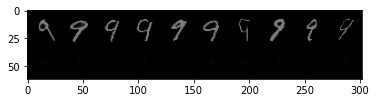

In [24]:
result_dir = f'./back_to_basics/leaveout_{opt.one_class}'
if not os.path.isdir(result_dir):
    os.makedirs(result_dir)
    print(f'creating {result_dir}')



ind_recon_pruned = []
ood_recon_pruned = []
ind_recon_mean_pruned = []
ood_recon_mean_pruned = []

auroc_pruned=[]
ind_recon_pruned_finetune = []
ood_recon_pruned_finetune = []
ind_recon_mean_pruned_finetune = []
ood_recon_mean_pruned_finetune = []

auroc_pruned_finetune=[]

pruned_models = dict()
pruned_finetuned_models=dict()
img_grids_for_inliers_pruned=dict()
img_grids_for_outliers_pruned=dict()
img_grids_for_inliers_pruned_finetuned=dict()
img_grids_for_outliers_pruned_finetuned=dict()



xaxis_range = [0,0.1,0.3,0.5,0.7,0.8,0.9,0.91,0.92,0.925,0.93,0.935,0.94,0.945,0.95,0.955,0.96,0.965,0.97,0.98,0.99]


for i, percent in enumerate(xaxis_range):
    print(percent)
    pruned_model = AE(opt.layer_num, opt.h_dim1, opt.h_dim2, opt.h_dim3,opt.h_dim4)
    model_name = 'MNIST_{}_{}_{}_{}_{}_{}'.format(opt.h_dim1, opt.h_dim2, opt.h_dim3, opt.h_dim4, opt.h_dim5, opt.h_dim6)
    model_path = model_name+'_holdout_{}_epoch_100.pth'.format(opt.one_class)
    pruned_model.load_state_dict(torch.load(os.path.join('../model-compression/trained_model',model_path),map_location=torch.device('cpu')))
    
    parameters_to_prune = (
        (pruned_model.encoder.fc1,'weight'),
        (pruned_model.encoder.fc2,'weight'),
        (pruned_model.encoder.fc3,'weight'),
        (pruned_model.encoder.fc4,'weight'),

        (pruned_model.decoder.fc1,'weight'),
        (pruned_model.decoder.fc2,'weight'),
        (pruned_model.decoder.fc3,'weight'),
        (pruned_model.decoder.fc4,'weight'),
    )
    
    prune.global_unstructured(
    parameters_to_prune,
    pruning_method = prune.L1Unstructured,
    amount=percent)
    
    pruned_models['{:.3f}'.format(percent)]=pruned_model
    
    pruned_model.eval()
    pruned_model.cuda()
    avg_loss = 0
    step = 0
    
    for i, (data,label) in enumerate(ind_loader):
        step += 1
        data = data.reshape(-1,784).cuda()
        with torch.no_grad():
            recon_error = pruned_model.recon_error(data)
        if i==0:
            ind_recon = recon_error
        else:
            ind_recon=torch.cat((ind_recon,recon_error),0)
            
    pruned_model.eval()
    avg_loss = 0
    step = 0
    for i, (data,label) in enumerate(ood_loader):
        step += 1
        data = data.reshape(-1,784).cuda()
        with torch.no_grad():
            recon_error = pruned_model.recon_error(data)
        if i==0:
            ood_recon = recon_error
        else:
            ood_recon=torch.cat((ood_recon,recon_error),0)
    
    ind_size=ind_recon.cpu().numpy().shape[0]
    ood_size=ood_recon.cpu().numpy().shape[0]

    auroc = metrics.roc_auc_score(np.concatenate((np.zeros(ind_size),np.ones(ood_size))),np.concatenate((ind_recon.cpu().numpy(),ood_recon.cpu().numpy())))
    print('before finetuning : auroc = {}'.format(auroc))

#     writer.add_scalar('weight_based/'.format(sparsity), ind_recon, i + 1)
    ind_recon_pruned.append(ind_recon)
    ood_recon_pruned.append(ood_recon)
    ind_recon_mean_pruned.append(torch.mean(ind_recon))
    ood_recon_mean_pruned.append(torch.mean(ood_recon))

    auroc_pruned.append(auroc)
    
    '''check inlier reconstruction'''
    test_data = torch.stack([ind_loader.dataset[i][0] for i in range(10)])
    recon = pruned_model(test_data.reshape(-1,784).cuda()).detach().cpu()
    recon = torch.clamp(recon.view(len(recon), 1, 28, 28), 0, 1)
    x_and_recon = torch.cat([test_data, recon])
    img_grid = make_grid(x_and_recon.detach().cpu(), nrow=10, range=(0, 1))
    # writer.add_image('supermask_{}/inlier_recon'.format(sparsity), img_grid, i+1)
    img_grids_for_inliers_pruned[percent]=img_grid.cpu().numpy().transpose(1,2,0)
    plt.imshow(img_grids_for_inliers_pruned[percent])
    plt.savefig(os.path.join(result_dir,'sparsity_{}_inlier_before_finetune.png'.format(percent)))
    
    test_data = torch.stack([ood_loader.dataset[i][0] for i in range(10)])
    recon = pruned_model(test_data.reshape(-1,784).cuda()).detach().cpu()
    recon = torch.clamp(recon.view(len(recon), 1, 28, 28), 0, 1)
    x_and_recon = torch.cat([test_data, recon])
    img_grid = make_grid(x_and_recon.detach().cpu(), nrow=10, range=(0, 1))
    # writer.add_image('supermask_{}/inlier_recon'.format(sparsity), img_grid, i+1)
    img_grids_for_outliers_pruned[percent]=img_grid.cpu().numpy().transpose(1,2,0)
    plt.imshow(img_grids_for_outliers_pruned[percent])
    plt.savefig(os.path.join(result_dir,'sparsity_{}_outlier_before_finetune.png'.format(percent)))

    
    print(
        "Global sparsity before finetuned: {:.2f}%".format(
            100. * float(
                torch.sum(pruned_model.encoder.fc1.weight == 0)
                + torch.sum(pruned_model.encoder.fc2.weight == 0)
                + torch.sum(pruned_model.encoder.fc3.weight == 0)
                + torch.sum(pruned_model.encoder.fc4.weight == 0)

                + torch.sum(pruned_model.decoder.fc1.weight == 0)
                + torch.sum(pruned_model.decoder.fc2.weight == 0)
                + torch.sum(pruned_model.decoder.fc3.weight == 0)
                + torch.sum(pruned_model.decoder.fc4.weight == 0)

            )
            / count_parameters(pruned_model)
            )
        )
    optimizer = torch.optim.Adam(pruned_model.parameters(), opt.lr)
    schedular = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=opt.finetune_epoch, eta_min=0, last_epoch=-1)

    time.sleep(5)
    pruned_model.train()
    for epoch in trange(1, opt.finetune_epoch+ 1):
        avg_loss = 0
        step = 0
        for (data,label) in train_loader:
            step += 1
            data = data.reshape(-1,784).cuda()
            optimizer.zero_grad()
            recon_error = pruned_model.recon_error(data)
            loss = torch.mean(recon_error)
            loss.backward()
            optimizer.step()
            avg_loss += loss
#             if i % 100 == 0:    
        print('Epoch [{}/{}] Batch [{}/{}]=> Loss: {:.5f}'.format(epoch, opt.finetune_epoch, i,len(train_loader), avg_loss / step))

    model_state = pruned_model.state_dict()
    #print(model_state)
    ckpt_name = '{}_holdout_{}_pruned_finetune'.format(model_name,opt.one_class,epoch)
    ckpt_path = os.path.join('../model-compression/trained_model',ckpt_name + ".pth")
    
    pruned_model.eval()
    pruned_model.cuda()
    avg_loss = 0
    step = 0
    
    for i, (data,label) in enumerate(ind_loader):
        step += 1
        data = data.reshape(-1,784).cuda()
        with torch.no_grad():
            recon_error = pruned_model.recon_error(data)
        if i==0:
            ind_recon = recon_error
        else:
            ind_recon=torch.cat((ind_recon,recon_error),0)
            
    pruned_model.eval()
    avg_loss = 0
    step = 0
    for i, (data,label) in enumerate(ood_loader):
        step += 1
        data = data.reshape(-1,784).cuda()
        with torch.no_grad():
            recon_error = pruned_model.recon_error(data)
        if i==0:
            ood_recon = recon_error
        else:
            ood_recon=torch.cat((ood_recon,recon_error),0)
    
    pruned_finetuned_models['{:.3f}'.format(percent)]=pruned_model
    ind_size=ind_recon.cpu().numpy().shape[0]
    ood_size=ood_recon.cpu().numpy().shape[0]

    auroc = metrics.roc_auc_score(np.concatenate((np.zeros(ind_size),np.ones(ood_size))),np.concatenate((ind_recon.cpu().numpy(),ood_recon.cpu().numpy())))
    print('after finetuning : auroc = {}'.format(auroc))
    ind_recon_pruned_finetune.append(ind_recon)
    ood_recon_pruned_finetune.append(ood_recon)
    ind_recon_mean_pruned_finetune.append(torch.mean(ind_recon))
    ood_recon_mean_pruned_finetune.append(torch.mean(ood_recon))

    auroc_pruned_finetune.append(auroc)
    
    print(
        "Global sparsity after finetuned: {:.2f}%".format(
            100. * float(
                torch.sum(pruned_model.encoder.fc1.weight == 0)
                + torch.sum(pruned_model.encoder.fc2.weight == 0)
                + torch.sum(pruned_model.encoder.fc3.weight == 0)
                + torch.sum(pruned_model.encoder.fc4.weight == 0)

                + torch.sum(pruned_model.decoder.fc1.weight == 0)
                + torch.sum(pruned_model.decoder.fc2.weight == 0)
                + torch.sum(pruned_model.decoder.fc3.weight == 0)
                + torch.sum(pruned_model.decoder.fc4.weight == 0)

            )
            / count_parameters(pruned_model)
            )
        )
    
    '''check inlier reconstruction'''
    test_data = torch.stack([ind_loader.dataset[i][0] for i in range(10)])
    recon = pruned_model(test_data.reshape(-1,784).cuda()).detach().cpu()
    recon = torch.clamp(recon.view(len(recon), 1, 28, 28), 0, 1)
    x_and_recon = torch.cat([test_data, recon])
    img_grid = make_grid(x_and_recon.detach().cpu(), nrow=10, range=(0, 1))
    # writer.add_image('supermask_{}/inlier_recon'.format(sparsity), img_grid, i+1)
    img_grids_for_inliers_pruned_finetuned[percent]=img_grid.cpu().numpy().transpose(1,2,0)
    plt.imshow(img_grids_for_inliers_pruned_finetuned[percent])
    plt.savefig(os.path.join(result_dir,'sparsity_{}_inlier_after_finetune.png'.format(percent)))

    test_data = torch.stack([ood_loader.dataset[i][0] for i in range(10)])
    recon = pruned_model(test_data.reshape(-1,784).cuda()).detach().cpu()
    recon = torch.clamp(recon.view(len(recon), 1, 28, 28), 0, 1)
    x_and_recon = torch.cat([test_data, recon])
    img_grid = make_grid(x_and_recon.detach().cpu(), nrow=10, range=(0, 1))
    # writer.add_image('supermask_{}/inlier_recon'.format(sparsity), img_grid, i+1)
    img_grids_for_outliers_pruned_finetuned[percent]=img_grid.cpu().numpy().transpose(1,2,0)
    plt.imshow(img_grids_for_outliers_pruned_finetuned[percent])
    plt.savefig(os.path.join(result_dir,'sparsity_{}_outlier_after_finetune.png'.format(percent)))



In [25]:
ind_recon_mean_pruned=torch.stack(ind_recon_mean_pruned)
ood_recon_mean_pruned=torch.stack(ood_recon_mean_pruned)
ind_recon_mean_pruned_finetune=torch.stack(ind_recon_mean_pruned_finetune)
ood_recon_mean_pruned_finetune=torch.stack(ood_recon_mean_pruned_finetune)

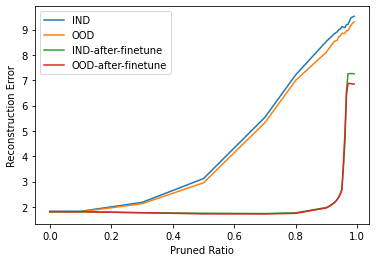

In [26]:
plt.plot(xaxis_range,ind_recon_mean_pruned.cpu().numpy())
plt.plot(xaxis_range,ood_recon_mean_pruned.cpu().numpy())
plt.plot(xaxis_range,ind_recon_mean_pruned_finetune.cpu().numpy())
plt.plot(xaxis_range,ood_recon_mean_pruned_finetune.cpu().numpy())

plt.xlabel('Pruned Ratio')
plt.ylabel('Reconstruction Error')
plt.legend(['IND','OOD','IND-after-finetune','OOD-after-finetune'])
plt.savefig('{}/pruned_ratio_RE.png'.format(result_dir))

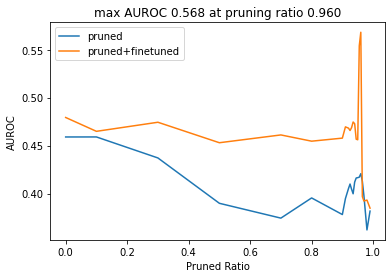

In [27]:
plt.plot(xaxis_range,auroc_pruned)
plt.plot(xaxis_range,auroc_pruned_finetune)
plt.xlabel('Pruned Ratio')
plt.ylabel('AUROC')
plt.legend(['pruned','pruned+finetuned'])
plt.title('max AUROC {:.3f} at pruning ratio {:.3f}'.format(np.max(auroc_pruned_finetune), xaxis_range[int(np.argmax(auroc_pruned_finetune))]))
plt.savefig('{}/pruned_ratio_AUROC.png'.format(result_dir))

In [28]:
def intermediate_scores(pr,layer):

    for i, (data,label) in enumerate(ind_loader):
        data = data.reshape(-1,784).cuda()
        pr_ft_int, _ = pruned_finetuned_models['{:.3f}'.format(pr)].intermediate(data,layer)
        org_int, _ = model.intermediate(data,layer)
        diff = torch.norm(pr_ft_int-org_int,dim=1)
        
        if i==0:
            ind_recon = diff
        else:
            ind_recon=torch.cat((ind_recon,diff),0)

    for i, (data,label) in enumerate(ood_loader):
        data = data.reshape(-1,784).cuda()
        pr_ft_int, _ = pruned_finetuned_models['{:.3f}'.format(pr)].intermediate(data,layer)
        org_int, _ = model.intermediate(data,layer)
        diff = torch.norm(pr_ft_int-org_int,dim=1)
        if i==0:
            ood_recon = diff
        else:
            ood_recon=torch.cat((ood_recon,diff),0)
    
    return ind_recon.detach().cpu().numpy(), ood_recon.detach().cpu().numpy()


Text(0.5, 1.0, '96.00% pruned+finetuned, AUROC=0.459')

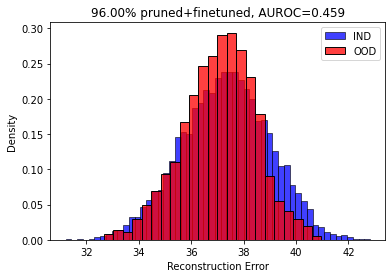

In [29]:
percent = 0.96
layer =0

ind,ood = intermediate_scores(percent,layer)
sns.histplot(ind,color='blue',stat='density')
sns.histplot(ood,color='red',stat='density')
ind_size = ind.shape[0]
ood_size = ood.shape[0]
auroc = metrics.roc_auc_score(np.concatenate((np.zeros(ind_size),np.ones(ood_size))),np.concatenate((ind,ood)))
plt.legend(['IND','OOD'])
plt.xlabel('Reconstruction Error')
plt.title('{:.2f}% pruned+finetuned, AUROC={:.3f}'.format(100*percent,auroc))
# plt.savefig('{}/pruned_finetuned_best_histogram.png'.format(result_dir))

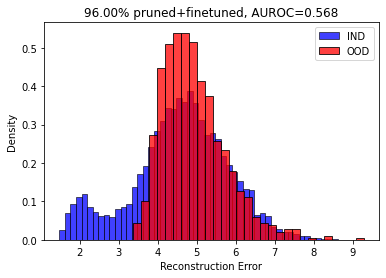

In [30]:
number = int(np.argmax(auroc_pruned_finetune))
sns.histplot(ind_recon_pruned_finetune[number].detach().cpu().numpy(),color='blue',stat='density')
sns.histplot(ood_recon_pruned_finetune[number].detach().cpu().numpy(),color='red',stat='density')
plt.legend(['IND','OOD'])
plt.xlabel('Reconstruction Error')
plt.title('{:.2f}% pruned+finetuned, AUROC={:.3f}'.format(100*xaxis_range[number],auroc_pruned_finetune[number]))
plt.savefig('{}/pruned_finetuned_best_histogram.png'.format(result_dir))

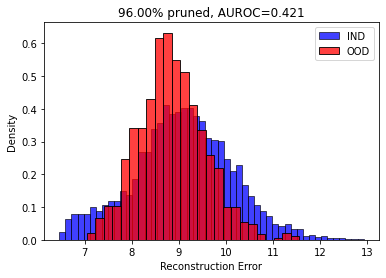

In [31]:
number = int(np.argmax(auroc_pruned_finetune))
sns.histplot(ind_recon_pruned[number].detach().cpu().numpy(),color='blue',stat='density')
sns.histplot(ood_recon_pruned[number].detach().cpu().numpy(),color='red',stat='density')
plt.legend(['IND','OOD'])
plt.xlabel('Reconstruction Error')
plt.title('{:.2f}% pruned, AUROC={:.3f}'.format(100*xaxis_range[number],auroc_pruned[number]))
plt.savefig('{}/pruned_best_histogram.png'.format(result_dir))

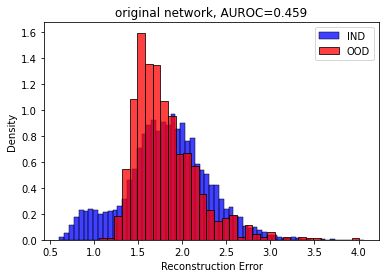

In [32]:
number = 0
sns.histplot(ind_recon_pruned[number].detach().cpu().numpy(),color='blue',stat='density')
sns.histplot(ood_recon_pruned[number].detach().cpu().numpy(),color='red',stat='density')
plt.legend(['IND','OOD'])
plt.xlabel('Reconstruction Error')
plt.title('original network, AUROC={:.3f}'.format(auroc_pruned[number]))
plt.savefig('{}/original_histogram.png'.format(result_dir))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


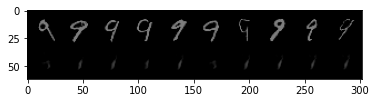

In [33]:
index_percent =0.965
plt.imshow(img_grids_for_outliers_pruned_finetuned[index_percent])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


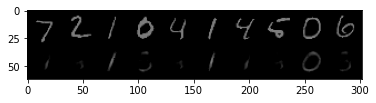

In [34]:
plt.imshow(img_grids_for_inliers_pruned_finetuned[index_percent])